In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 

%reload_ext autoreload
%aimport Funcs
%aimport fluid_flow
%aimport parameters
%aimport visualization
from Funcs import advance_adv_diff_RK3, advance_adv_diff_RK4
from fluid_flow import advance_fluid_flow, set_boundary, dt_fluid_flow

from parameters import * # <-- dangerous; make sure to put only global constants in that file

In [25]:
N = 130
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,N)
dt = dt_fluid_flow(dx, Fo=0.3)
dt

4.807403401237907e-06

## stationnarity
We define some metrics which compare two arrays $a$ and $b$. In our case this will be $u$ or $v$ at different times $T_n$ of the simulation.

In [26]:
from Funcs import metric_L0, metric_RMS

Next, we define $t_n = n \cdot Nt \,  \Delta t + t_0$ of the simulation, where $n = 1,.., N_{loop}$, $t_0 = N_{t_0} \Delta t$ is the initial time given to the simulation before starting with the actual analysis (we are not interested in the strong fluctuations at the very beginning). Furthermore, one can chose $N_t \gg 1$ since we don't need to compare the results after every single time step.

In [27]:
from math import sin, pi, exp
from poisson_solver import get_atol
import time
dt = dt_fluid_flow(dx, Fo=0.3)

# initial setup of velocity field
u0 = np.zeros((N,N))
v0 = np.copy(u0)
u0,v0 = set_boundary(u0,v0,Ns_c, Nc_lw)
u, v = np.copy(u0), np.copy(v0)

# convergence paramater for the Poisson solver:
amax     = 1e-4 # initial value for atol at t=0
amin     = 1e-8 # value at tmax
tmax     = 0.01 # atol = amax for t > tmax

# w parameter for the Poisson solver:
w = 2 / (1 + sin(pi/N))

# total simulation time
t = 0.025

# time in [s] between two measurements
dt_measure = t / 100

# number of iterations between 2 convergence measurements
Nt = int(dt_measure / dt)

# number of convergence measurements
N_loop = int(t / dt_measure)

# placeholders for the respective metrics
L0 = np.zeros((2,N_loop))
L2 = np.zeros_like(L0)

# we don't need to check the convergence of the Poisson solver at each iteration (of the P.Solver),
# this will allow to save some time as N becomes large (here, we chose n_conv_check=1 for N=30)
n_conv_check = int(np.round(8.9e-5/dt))

# initial warm-up:
Nt0=1
u, v, P,_ = advance_fluid_flow(Nt0, u, v, advance_adv_diff_RK3, dt)

t0 = time.time()
# convergence analysis:
for i in range(N_loop):
    
    t = i * dt * Nt + dt * Nt0 # current phyiscal time in [s]
    atol = get_atol(t, amin, amax, tmax)
    
    u_old, v_old = np.copy(u), np.copy(v)
    u, v, P,_ = advance_fluid_flow(Nt, u, v, advance_adv_diff_RK3, dt, w=w, atol=atol, P=P, n_conv_check=n_conv_check)
    
    # measurements:
    L0[0,i] = metric_L0(u_old, u)
    L0[1,i] = metric_L0(v_old, v) 
    
    L2[0,i] = metric_RMS(u_old, u)
    L2[1,i] = metric_RMS(v_old, v)
print('CPU time [s]: ', time.time() - t0)

CPU time [s]:  108.79919648170471


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
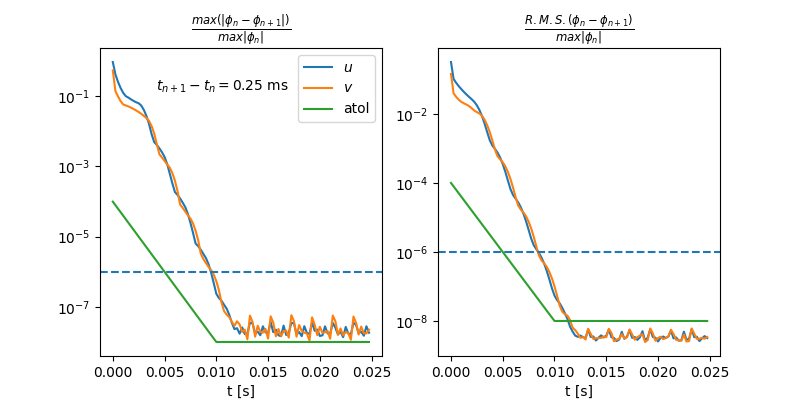

In [29]:
T = np.arange(N_loop) * dt * Nt + dt * Nt0

fig, [ax, ax2] = plt.subplots(1,2, figsize=(8,4), sharex=True)
ax.plot(T, L0[0], label='$u$')
ax.plot(T, L0[1], label='$v$')

ax2.plot(T, L2[0], label='$u$')
ax2.plot(T, L2[1], label='$v$')

ax.set_xlabel('t [s]')
ax2.set_xlabel('t [s]')
if True:
    ax.set_yscale('log')
    ax2.set_yscale('log')
    #ax.set_xscale('log')
    #ax2.set_xscale('log')

ax.set_title(r'$\frac{ max ( |\phi_n - \phi_{n+1}| ) } { max |\phi_n| }$')
ax2.set_title(r'$\frac{ R.M.S.( \phi_n - \phi_{n+1} ) }{ max |\phi_n| }$')

s = r'$t_{n+1} - t_n = $' +'${:.2f}$ ms'.format(dt_measure * 1e3)
ax.text(0.2, 0.9, s, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes)
for a in [ax, ax2]:
    a.axhline(1e-6, ls='--')
    #a.set_xlim(left=1e-3)
    a.plot(T, get_atol(T, amin, amax, tmax), label='atol')
ax.legend()

Make a nicer plot for the presentation:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
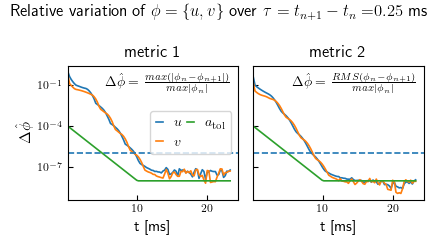

In [24]:
%autoreload 1
from visualization import plot_station_analysis

from plotting import set_size
plt.style.use('tex.mplstyle')
figsize = set_size(fraction=.7, aspect_r=0.4)
fig, axs = plt.subplots(1,2,sharex=True, sharey=True, figsize=figsize)
plot_station_analysis(L0, L2, Nt, Nt0, N_loop, dt, dt_measure, fluid=True, axs=axs)

# display variation of atol:
T = np.arange(N_loop) * dt * Nt + dt * Nt0
for ax in axs:
    ax.plot(T * 1e3, get_atol(T, amin, amax, tmax), label='$a_\mathrm{tol}$')
axs[0].legend(loc='center right', handlelength=0.5, ncol=2, columnspacing=0.4)
plt.tight_layout()

if True:
    fig.savefig('figures/fluif_flow_station.svg')
    plt.style.use('default')

We will **define** a time $t_{stat} = 0.015 s$, for which we see that the maximum relative fluctuations (L0 metric) has dropped sufficiently.

**Maximum strain rate**

what is max($|\frac{\partial v}{\partial y}|$) ?


In [14]:
from Funcs import df1_2
a = np.abs(df1_2(v, dy, axis=1))
print(np.max(a[0,:]))

1490.0169184906808


In [15]:
np.max(np.abs(u)),np.max(np.abs(v)) 

(1.189567885948802, 1.0015461960541268)

We can save the velocity field for later use:

## Visualization

In [28]:
from visualization import plot_velocity_image, plot_velocity_vector_field

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
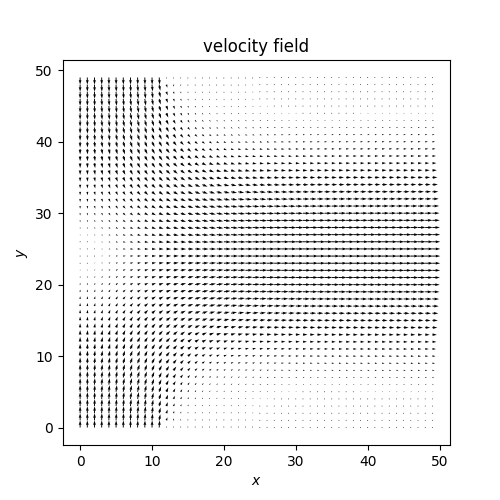

In [29]:
plot_velocity_vector_field(u,v)

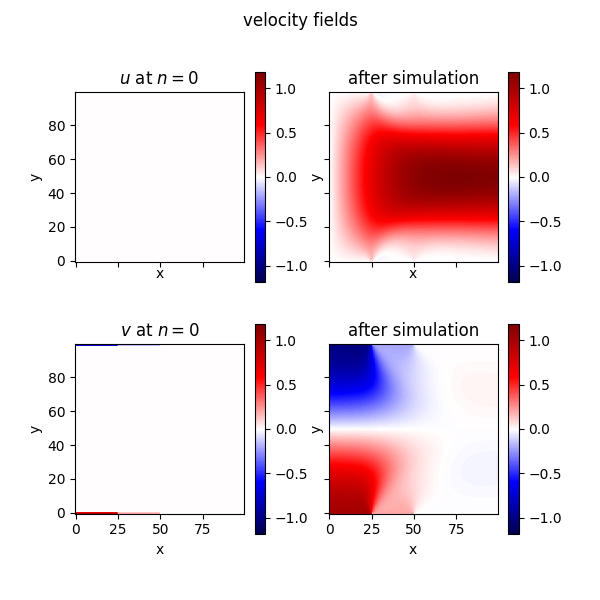

In [13]:
from visualization import plot_velocity_image
plot_velocity_image(u,v,u0,v0)

Now with the help of a modified advance_fluid_flow function we save data for multiple N values in the first 7ms of the flow I have prooven previously that the system is stationnary at around 6.3ms and save data for different N values and save them 